## Options and Libraries

In [1]:
# this will make sure the root folder is the current working directory
from os import chdir, getcwd
from pyprojroot.here import here
chdir(here())
getcwd()

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# main libs
import pandas as pd
import numpy as np

# graphic libs
from matplotlib import pyplot as plt
import seaborn as sns

## Read data

In [3]:
df = pd.read_parquet("data/02_inter/df_01_first_look.parquet")
# data with minor modifications from 01_eda_first_look.ipynb

# one hot
df_full_dummies = pd.get_dummies(df, drop_first=False)

# Convert to integer days since 1970-01-01 (unix epoch)
df_full_dummies['dt_customer'] = (df_full_dummies['dt_customer'] - pd.Timestamp('1970-01-01')).dt.days

df_full_dummies.drop(columns=["income", "z_cost_contact", "z_revenue"], inplace=True)

df_full_dummies.head()

,id,year_birth,kidhome,teenhome,dt_customer,recency,mnt_wines,mnt_fruits,mnt_meat_products,mnt_fish_products,mnt_sweet_products,mnt_gold_prods,num_deals_purchases,num_web_purchases,num_catalog_purchases,num_store_purchases,num_web_visits_month,accepted_cmp3,accepted_cmp4,accepted_cmp5,accepted_cmp1,accepted_cmp2,complain,response,income_pred,mnt_total,num_total,education_2n Cycle,education_Basic,education_Graduation,education_Master,education_PhD,marital_status_Divorced,marital_status_Married,marital_status_Single,marital_status_Together,marital_status_Widow
0,5524,1957,0,0,15587,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,80285.334960,1617,32,False,False,True,False,False,False,False,True,False,False
1,2174,1954,1,1,16137,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,38786.354474,27,11,False,False,True,False,False,False,False,True,False,False
2,4141,1965,0,0,15938,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,56093.137936,776,25,False,False,True,False,False,False,False,False,True,False
3,6182,1984,1,0,16111,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,34301.144730,53,14,False,False,True,False,False,False,False,False,True,False
4,5324,1981,1,0,16089,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,45083.947036,422,24,False,False,False,False,True,False,True,False,False,False


## Gaussian Mixture Classifier

In [4]:
from sklearn.mixture import GaussianMixture
# gaussian mixture
n_clusters = 5 
gmm = GaussianMixture(n_components=n_clusters)  # Specify the number of components
gmm.fit(df_full_dummies)
gmm_pred_proba_array = gmm.predict_proba(df_full_dummies)
gmm_pred_cluster = gmm.predict(df_full_dummies)

In [5]:
column_names = [f'prob_clst_{i}' for i in range(1, n_clusters + 1)]
df_gmm_pred_proba = pd.DataFrame(gmm_pred_proba_array, columns=column_names)
df_gmm_pred_proba['pred_clst'] = (gmm_pred_cluster+1) # add one to start at 1, not 0
df_gmm_pred_proba.head()

,prob_clst_1,prob_clst_2,prob_clst_3,prob_clst_4,prob_clst_5,pred_clst
0,1.000000,0.000000e+00,9.821248e-52,6.022950e-08,0.0,1
1,0.000000,1.000000e+00,3.510992e-17,3.916444e-23,0.0,2
2,0.000299,2.459507e-49,9.997010e-01,1.726860e-12,0.0,3
3,0.000000,1.000000e+00,3.393789e-13,2.502945e-23,0.0,2
4,0.000000,3.875618e-05,9.999612e-01,7.383019e-11,0.0,3


In [6]:
# make sure same number of rows for df and predictions
assert df_full_dummies.shape[0]==gmm_pred_proba_array.shape[0]

# Append to existing DataFrame
df_predicted = pd.concat(
    [df_full_dummies.reset_index(drop=True),
    df_gmm_pred_proba.reset_index(drop=True)], axis=1, ignore_index=False)

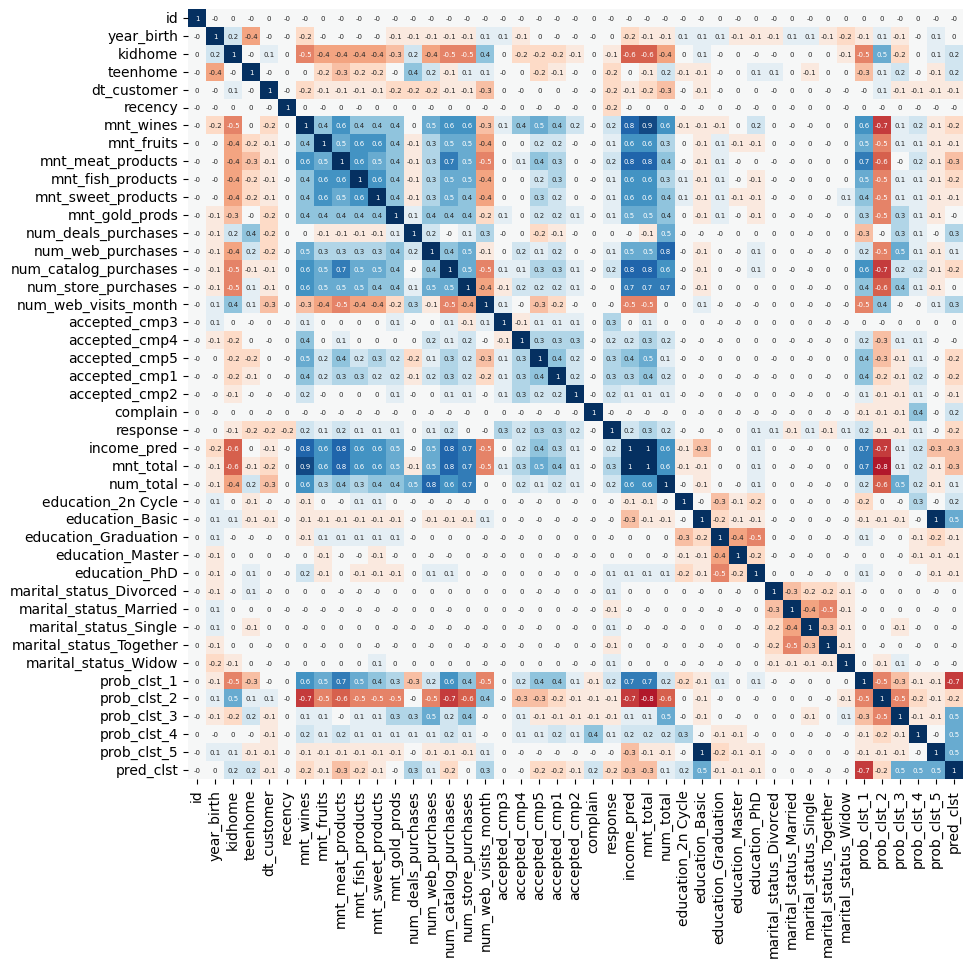

In [7]:
# get correlations 
df_predicted_encoded = pd.get_dummies(df_predicted, drop_first=False)
df_corr = df_predicted_encoded.corr()

# heatmap
from matplotlib import pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(
    round(df_corr,1), 
    cmap='RdBu',
    annot=True,
    annot_kws={"size": 5},
    vmin=-1, vmax=1,
    cbar=False
)
# save the plot as JPG file
plt.savefig(
    f"output/figures/fig_corrplot_first_look_{n_clusters}_clst.png",
    dpi=300,
    bbox_inches='tight'
)

plt.show()

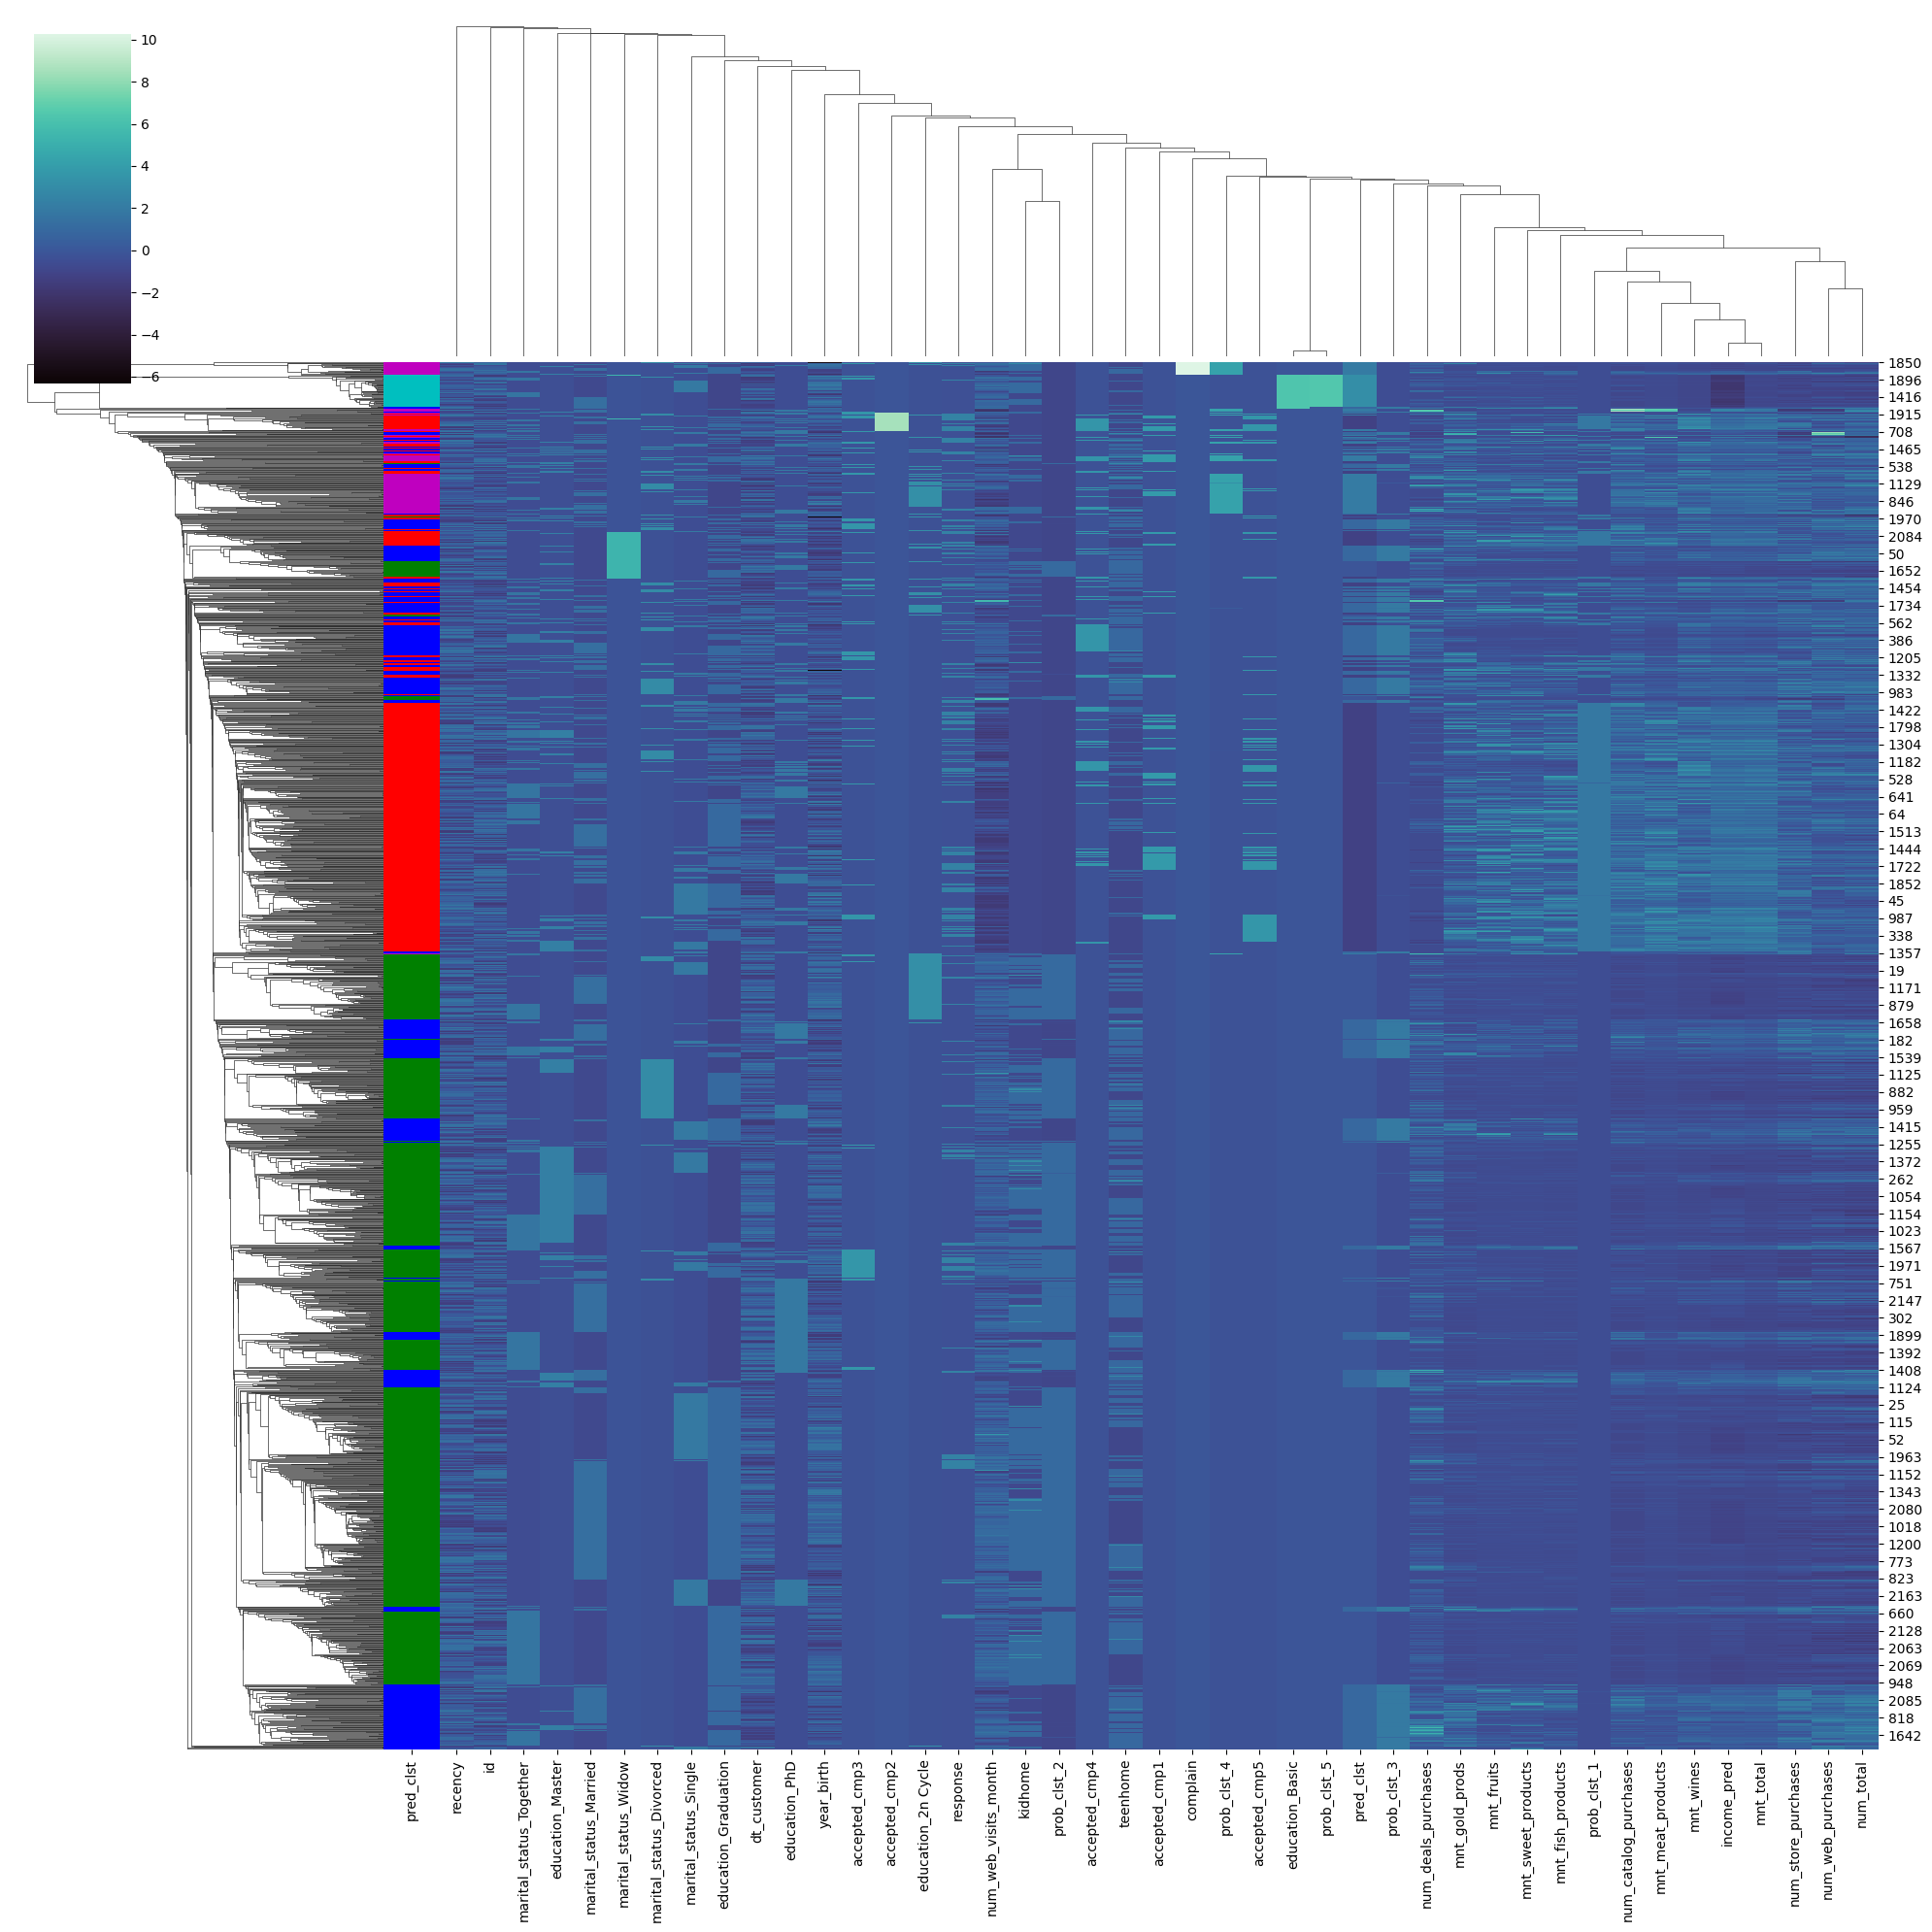

In [8]:
colors = ["r", "g", "b", "c", "m", "y", "k"]  # at least number of cluster
pred_clst = df_predicted["pred_clst"]
unique_values = pred_clst.unique()
lut = dict(zip(unique_values, colors[:len(unique_values)]))
row_colors = pred_clst.map(lut)

# Convert only boolean columns to numeric (1 for True, 0 for False)
df_dendo = df_predicted_encoded
df_dendo[df_dendo.select_dtypes(include='bool').columns] = df_dendo.select_dtypes(include='bool').astype(int)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    sns.clustermap(df_dendo, row_colors=row_colors, figsize=(20,20), 
    cmap="mako", metric="correlation", method="single", z_score=1)

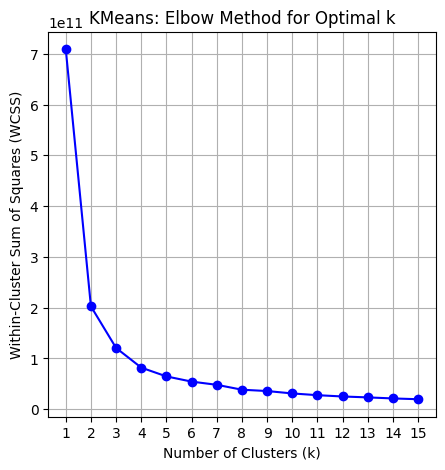

In [9]:
from sklearn.cluster import KMeans

# Calculate WCSS for a range of cluster numbers
wcss = []
k_values = range(1, 15+1)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, init="k-means++", max_iter=1000)
    kmeans.fit(df_full_dummies)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow Method graph
plt.figure(figsize=(5, 5))
plt.plot(k_values, wcss, marker='o', linestyle='-', color='b')
plt.title("KMeans: Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [10]:
def calculate_wcss(gmm, X):
    """Calculate WCSS from a fitted Gaussian Mixture Model.
    
    Parameters:
        gmm: Fitted GaussianMixture model.
        X: Data used to fit the GMM (numpy array).
    
    Returns:
        WCSS: Within-Cluster Sum of Squares.
    """
    labels = gmm.predict(X)
    return sum(
        np.sum(np.linalg.norm(X[labels == i] - mean, axis=1) ** 2)
        for i, mean in enumerate(gmm.means_)
    )

In [11]:
def clustering_statistics(X, labels):
    """Calculate clustering evaluation metrics and return as a DataFrame."""
    from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
    metrics = {
        'silhouette_score': silhouette_score(X, labels),
        'calinski_harabasz_score': calinski_harabasz_score(X, labels),
        'davies_bouldin_score': davies_bouldin_score(X, labels),
    }
    return pd.DataFrame([metrics])

In [12]:
# Predict cluster labels
X = df_full_dummies
labels = gmm.predict(X)

# Calculate clustering statistics
stats = clustering_statistics(X, labels)
print(stats)

   silhouette_score  calinski_harabasz_score  davies_bouldin_score
0          0.261882               1548.97634              1.804058


In [13]:
# Predict cluster labels
X = df_full_dummies

# Placeholder for results
results = []

k_values = range(2, 7+1) # clusters (starts k=2 because metrics need at least 2 clusters)
for k in k_values:
    
    # Fit Gaussian Mixture Model
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X)
    labels = gmm.predict(X)
    
    # calc clustering statistics
    stats = clustering_statistics(X, labels)
    
    # Add the number of clusters as a new column
    stats['k'] = k
    
    # Append the results
    results.append(stats)

# Concatenate all results into a single DataFrame
final_stats = pd.concat(results, ignore_index=True)
final_stats

,silhouette_score,calinski_harabasz_score,davies_bouldin_score,k
0,0.504725,3548.138997,0.654125,2
1,0.318223,2050.686235,1.375237,3
2,0.271453,1772.208161,1.997641,4
3,0.062774,1154.206082,3.929716,5
4,-0.075335,924.173372,2.923596,6
5,-0.077581,883.477031,7.824499,7


- silhouette_score: goes from -1 to +1, higher is better defined clusters
- calinski_harabasz_score: a ratio, higher is better
- davies_bouldin_score: lower is better, minimum value is 0


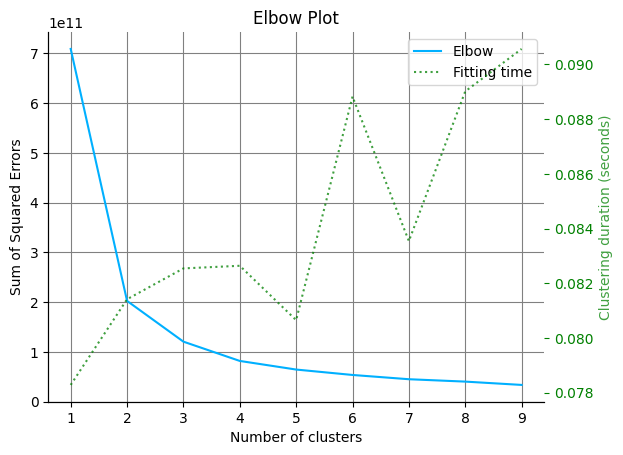

In [14]:
from sklearn_evaluation import plot
model = KMeans(n_init="auto", random_state=424242)
_ = plot.elbow_curve(X, model, range_n_clusters=(1, 2, 3, 4, 5, 6, 7, 8, 9))